In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gdown
import os

if not os.path.exists('data.csv'):
    file_id = '1F6b961eijthkGNWuA217IqlzwHM9k_4a'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'data.csv', quiet=False)

# Data loading
df = pd.read_csv('data.csv')
data = df[['userId', 'movieId', 'rating', 'timestamp']].to_numpy()

# Mappings
user_ids = np.unique(data[:, 0])
movie_ids = np.unique(data[:, 1])
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

M = len(user_ids)
N = len(movie_ids)

# User Index
user_index = [[] for _ in range(M)]
for row in data:
    user_idx = user_id_to_idx[row[0]]
    movie_idx = movie_id_to_idx[row[1]]
    user_index[user_idx].append((movie_idx, row[2], row[3]))

# Sort by timestamp
for i in range(M):
    user_index[i].sort(key=lambda x: x[2])

# Train/Test Split
train_by_user = [[] for _ in range(M)]
test_by_user = [[] for _ in range(M)]

# Optimization: Pre-build Item Index for Training
train_by_item = [[] for _ in range(N)]

for user_idx in range(M):
    if len(user_index[user_idx]) > 0:
        # Train split
        train_items = user_index[user_idx][:-1]
        train_by_user[user_idx] = train_items

        for movie_idx, rating, _ in train_items:
            train_by_item[movie_idx].append((user_idx, rating))

        # Test split
        test_by_user[user_idx] = user_index[user_idx][-1:]

print(f"Users: {M}, Movies: {N}")
print(f"Train ratings: {sum(len(x) for x in train_by_user)}")
print(f"Test ratings: {sum(len(x) for x in test_by_user)}")

Users: 200948, Movies: 84432
Train ratings: 31799256
Test ratings: 200948


In [ ]:
# Hyperparameters
lambda_val = 0.1
gamma_val = 0.1
max_iters = 20

# Initialization
user_biases = np.zeros(M)
item_biases = np.zeros(N)

all_train_ratings = [r for u_list in train_by_user for _, r, _ in u_list]
global_mean = np.mean(all_train_ratings)

# Metric storage
train_rmse_history = []
test_rmse_history = []
loss_history = []

def get_rmse(data_index, u_b, i_b, g_mean):
    errors = []
    for u in range(M):
        for m, r, _ in data_index[u]:
            pred = g_mean + u_b[u] + i_b[m]
            errors.append((r - pred) ** 2)
    return np.sqrt(np.mean(errors)) if errors else 0

def get_loss(u_b, i_b, lam, gam):
    # Negative Log Likelihood
    sse = 0
    for u in range(M):
        for m, r, _ in train_by_user[u]:
            pred = global_mean + u_b[u] + i_b[m]
            sse += (r - pred) ** 2

    # Regularization (Prior)
    reg = gam * (np.sum(u_b**2) + np.sum(i_b**2))
    return 0.5 * (lam * sse + reg)

print(f"Starting ALS (Lambda={lambda_val}, Gamma={gamma_val})...")

# Alternating Least Squares Loop
for it in range(max_iters):
    start = time.time()

    # Update User Biases
    for u in range(M):
        if not train_by_user[u]: continue

        numerator = 0.0
        count = 0
        for m, r, _ in train_by_user[u]:
            numerator += lambda_val * (r - (global_mean + item_biases[m]))
            count += 1

        # Update rule: bias = numerator / (lambda * count + gamma)
        user_biases[u] = numerator / (lambda_val * count + gamma_val)

    # Update Item Biases
    for m in range(N):
        if not train_by_item[m]: continue

        numerator = 0.0
        count = 0
        for u, r in train_by_item[m]:
            numerator += lambda_val * (r - (global_mean + user_biases[u]))
            count += 1

        item_biases[m] = numerator / (lambda_val * count + gamma_val)

    # Metrics Computation
    train_rmse = get_rmse(train_by_user, user_biases, item_biases, global_mean)
    test_rmse = get_rmse(test_by_user, user_biases, item_biases, global_mean)
    loss = get_loss(user_biases, item_biases, lambda_val, gamma_val)

    train_rmse_history.append(train_rmse)
    test_rmse_history.append(test_rmse)
    loss_history.append(loss)

    print(f"Iter {it+1}: Loss={loss:.2f}, Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f} ({time.time()-start:.2f}s)")

Starting ALS (Lambda=0.1, Gamma=0.1)...
Iter 1: Loss=1184037.73, Train RMSE=0.8616, Test RMSE=0.9368 (131.56s)
Iter 2: Loss=1144466.56, Train RMSE=0.8472, Test RMSE=0.9232 (128.09s)
Iter 3: Loss=1142576.68, Train RMSE=0.8464, Test RMSE=0.9231 (127.18s)
Iter 4: Loss=1142448.59, Train RMSE=0.8464, Test RMSE=0.9231 (130.27s)
Iter 5: Loss=1142430.20, Train RMSE=0.8464, Test RMSE=0.9231 (126.17s)
Iter 6: Loss=1142422.61, Train RMSE=0.8464, Test RMSE=0.9231 (126.62s)
Iter 7: Loss=1142416.81, Train RMSE=0.8464, Test RMSE=0.9230 (127.46s)
Iter 8: Loss=1142411.44, Train RMSE=0.8464, Test RMSE=0.9230 (124.92s)
Iter 9: Loss=1142406.23, Train RMSE=0.8464, Test RMSE=0.9230 (125.92s)
Iter 10: Loss=1142401.12, Train RMSE=0.8464, Test RMSE=0.9230 (126.06s)
Iter 11: Loss=1142396.10, Train RMSE=0.8464, Test RMSE=0.9230 (125.17s)
Iter 12: Loss=1142391.16, Train RMSE=0.8464, Test RMSE=0.9230 (126.87s)
Iter 13: Loss=1142386.31, Train RMSE=0.8464, Test RMSE=0.9230 (125.18s)
Iter 14: Loss=1142381.53, Train R

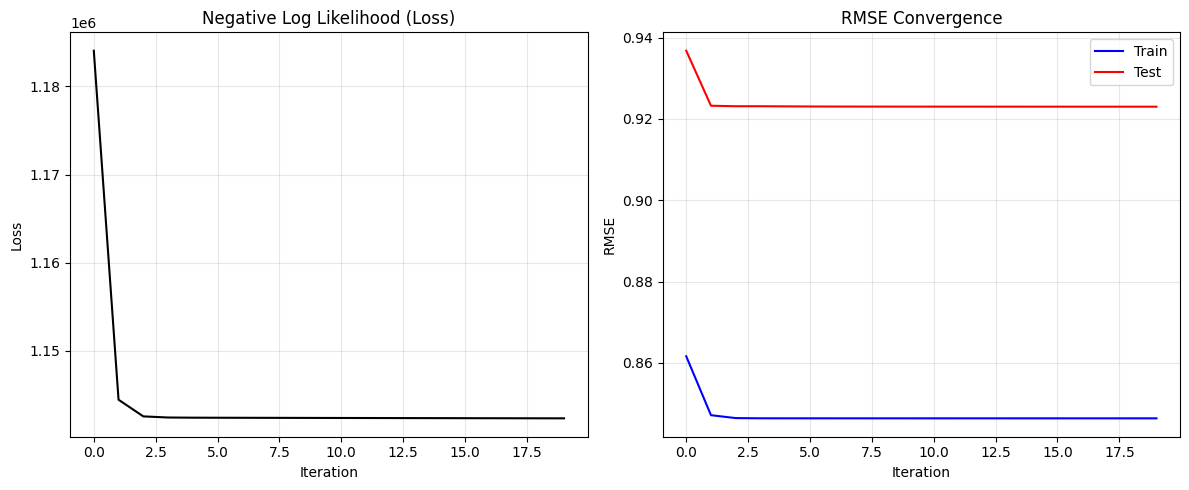

------------------------------
PRACTICAL 2 ANALYSIS
------------------------------
Global Mean: 3.5391
Final Train RMSE: 0.8464
Final Test RMSE:  0.9230
------------------------------
Status: Slight overfitting detected (expected with simple biases)


In [ ]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Plot
ax1.plot(loss_history, 'k-')
ax1.set_title('Negative Log Likelihood (Loss)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# RMSE Plot
ax2.plot(train_rmse_history, 'b-', label='Train')
ax2.plot(test_rmse_history, 'r-', label='Test')
ax2.set_title('RMSE Convergence')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Analysis
print("-" * 30)
print("PRACTICAL 2 ANALYSIS")
print("-" * 30)
print(f"Global Mean: {global_mean:.4f}")
print(f"Final Train RMSE: {train_rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {test_rmse_history[-1]:.4f}")
print("-" * 30)

if test_rmse_history[-1] > train_rmse_history[-1]:
    print("Status: Slight overfitting detected (expected with simple biases)")
else:
    print("Status: Model generalizes well")